# Random forest: Titanic


In [2]:
pip install -r ../requirements.txt


[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [4]:
url='https://raw.githubusercontent.com/4GeeksAcademy/random-forest-project-tutorial/main/titanic_train.csv'
df_raw = pd.read_csv(url)

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_raw.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [7]:
df_raw.describe(include='object')

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644

In [8]:
df_raw.sample(10)

PassengerId  Survived  Pclass  \
149          150         0       2   
283          284         1       3   
832          833         0       3   
308          309         0       2   
881          882         0       3   
686          687         0       3   
785          786         0       3   
779          780         1       1   
121          122         0       3   
359          360         1       3   

                                                  Name     Sex   Age  SibSp  \
149                  Byles, Rev. Thomas Roussel Davids    male  42.0      0   
283                         Dorking, Mr. Edward Arthur    male  19.0      0   
832                                     Saad, Mr. Amin    male   NaN      0   
308                                Abelson, Mr. Samuel    male  30.0      1   
881                                 Markun, Mr. Johann    male  33.0      0   
686                           Panula, Mr. Jaako Arnold    male  14.0      4   
785                 Harmer, Mr. Abraham (David Lishin)    male  25.0      0   
779  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  female  43.0      0   
121                         Moore, Mr. Leonard Charles    male   NaN      0   
359                  Mockler, Miss. Helen Mary "Ellie"  female   NaN      0   

     Parch      Ticket      Fare Cabin Embarked  
149      0      244310   13.0000   NaN        S  
283      0  A/5. 10482    8.0500   NaN        S  
832      0        2671    7.2292   NaN        C  
308      0   P/PP 3381   24.0000   NaN        C  
881      0      349257    7.8958   NaN        S  
686      1     3101295   39.6875   NaN        S  
785      0      374887    7.2500   NaN        S  
779      1       24160  211.3375    B3        S  
121      0   A4. 54510    8.0500   NaN        S  
359      0      330980    7.8792   NaN        Q

Check if there are duplicated passengers

In [9]:
df_duplicates = df_raw['PassengerId'].duplicated().sum()

print(f'It seems that there are {df_duplicates} duplicated passenger according to the PassengerId feature.')

It seems that there are 0 duplicated passenger according to the PassengerId feature.


Drop irrelevant columns

- For this, we create a new dataframe

In [10]:
df_transf = df_raw.copy()

drop_cols = ['PassengerId','Cabin', 'Ticket', 'Name']
df_transf = df_transf.drop(drop_cols, axis = 1)

### Basic EDA

In [11]:
df = df_transf.copy()

In [12]:
# Split the dataset so to avoid bias

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)

In [13]:
# Join the train sets to ease insights

df_train = pd.concat([X_train, y_train], axis=1)

In [14]:
# Get basic info

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 828 to 257
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    668 non-null    int64  
 1   Sex       668 non-null    object 
 2   Age       533 non-null    float64
 3   SibSp     668 non-null    int64  
 4   Parch     668 non-null    int64  
 5   Fare      668 non-null    float64
 6   Embarked  667 non-null    object 
 7   Survived  668 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 47.0+ KB


- Embarked and age have missing values

In [15]:
# Take a sample

df_train.sample(10)

Pclass     Sex   Age  SibSp  Parch     Fare Embarked  Survived
203       3    male  45.5      0      0   7.2250        C         0
738       3    male   NaN      0      0   7.8958        S         0
769       3    male  32.0      0      0   8.3625        S         0
861       2    male  21.0      1      0  11.5000        S         0
478       3    male  22.0      0      0   7.5208        S         0
844       3    male  17.0      0      0   8.6625        S         0
239       2    male  33.0      0      0  12.2750        S         0
445       1    male   4.0      0      2  81.8583        S         1
632       1    male  32.0      0      0  30.5000        C         1
8         3  female  27.0      0      2  11.1333        S         1

In [16]:
# Describe the numerical and date variables

df_train.describe()

Pclass         Age       SibSp       Parch        Fare    Survived
count  668.000000  533.000000  668.000000  668.000000  668.000000  668.000000
mean     2.300898   30.439174    0.505988    0.368263   31.207372    0.387725
std      0.834524   14.718435    1.080685    0.800494   46.007476    0.487596
min      1.000000    0.750000    0.000000    0.000000    0.000000    0.000000
25%      2.000000   21.000000    0.000000    0.000000    7.895800    0.000000
50%      3.000000   29.000000    0.000000    0.000000   13.860400    0.000000
75%      3.000000   39.000000    1.000000    0.000000   30.178100    1.000000
max      3.000000   80.000000    8.000000    6.000000  512.329200    1.000000

In [17]:
# Describe categorical variables

df_train.describe(include='object')

Sex Embarked
count    668      667
unique     2        3
top     male        S
freq     431      482

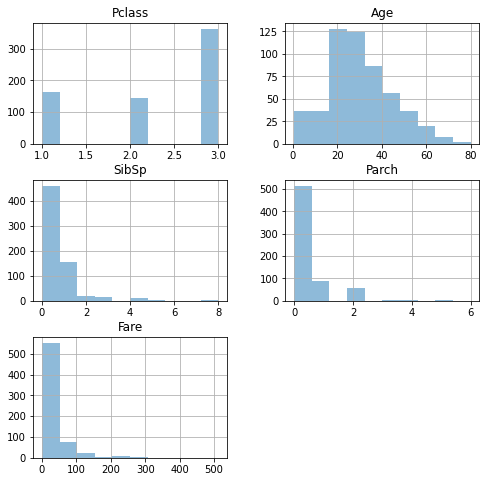

In [18]:
# Perform univariate analysis - histograms

X_train.hist(figsize=(8,8), alpha=0.5)
plt.show()

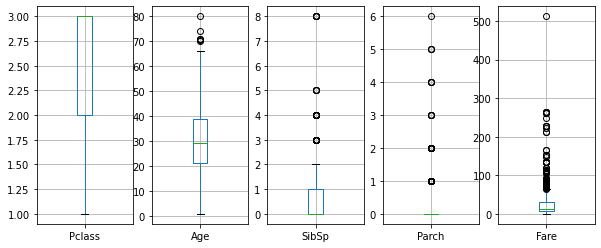

In [19]:
# Perform univariate analysis - boxplots

fig, ax = plt.subplots(1,5, figsize=(10,4))
axs = ax.flatten()
for i in range(len(axs)):
    X_train._get_numeric_data().iloc[:,i].to_frame().boxplot(ax=axs[i]) # solo graficamos las col numericas que son 3

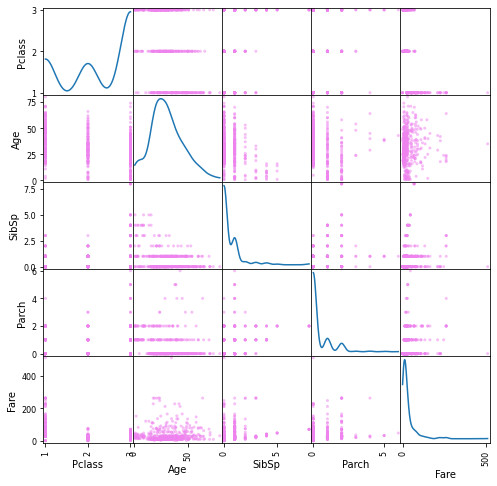

In [20]:
# Perform bivariate analysis - numericals

pd.plotting.scatter_matrix(X_train, diagonal='kde', figsize=(8,8), c='Violet')
plt.show()

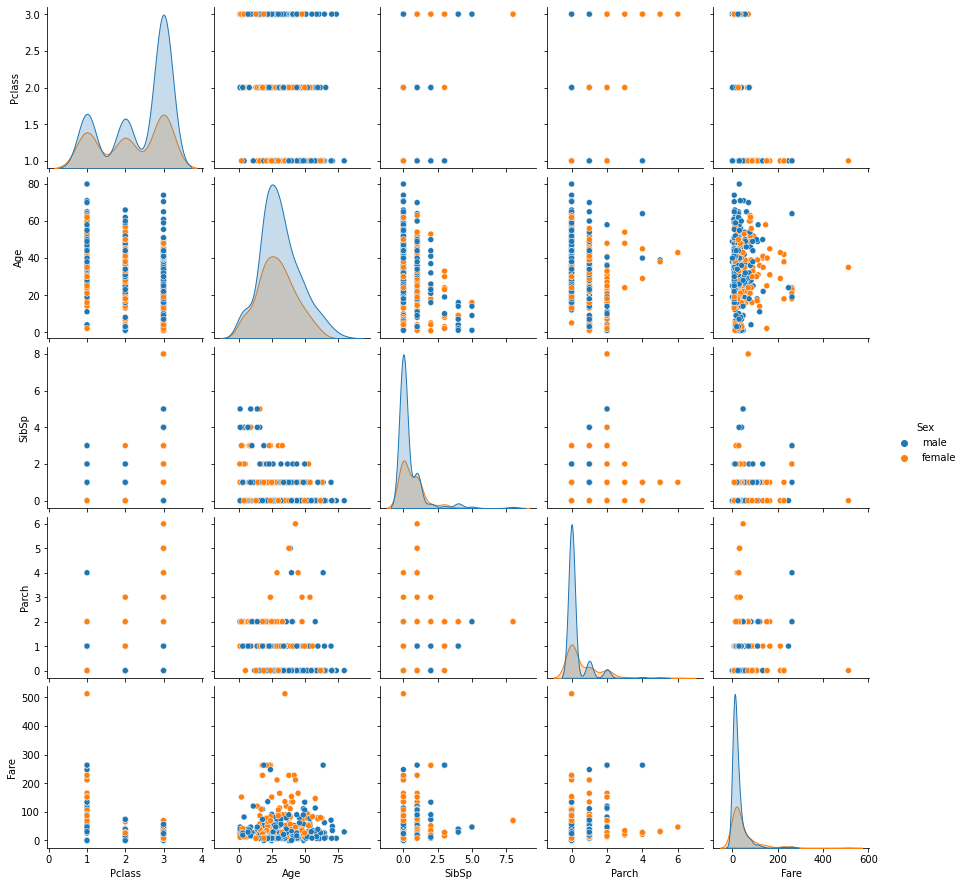

In [21]:
# Perform bivariate analysis per category

sns.pairplot(data=X_train, hue='Sex')
plt.show()

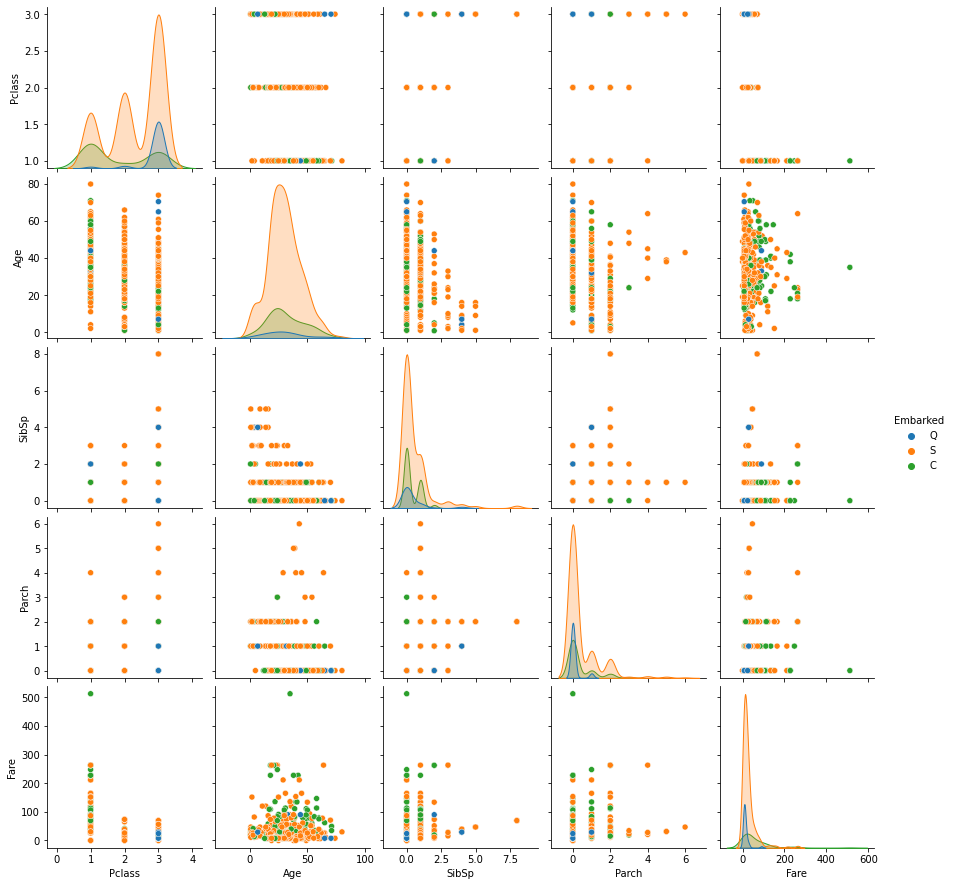

In [22]:
sns.pairplot(data=X_train, hue='Embarked')
plt.show()

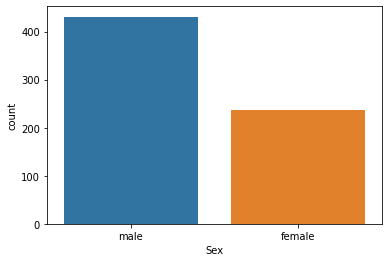

In [23]:
# Perform categorical analysis 

sns.countplot(data=X_train, x='Sex')

plt.show()

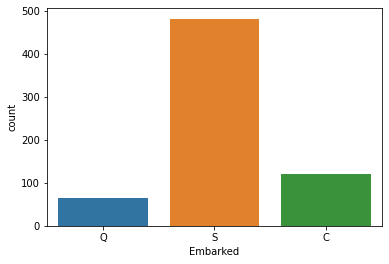

In [24]:
# Perform categorical analysis 

sns.countplot(data=X_train, x='Embarked')

plt.show()

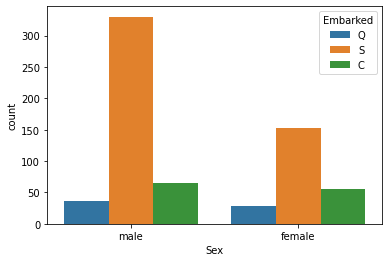

In [25]:
# Perform bivariate categorical analysis 

sns.countplot(data=X_train, x='Sex', hue='Embarked')

plt.show()

In [26]:
# 2.10 Perform correlation analysis - Pearson

X_train.corr().style.background_gradient(cmap='Blues')

In [27]:
# Analyze effect on response variable (DV)

df_train.corr().style.background_gradient(cmap='Blues')

<AxesSubplot:xlabel='Survived', ylabel='Age'>

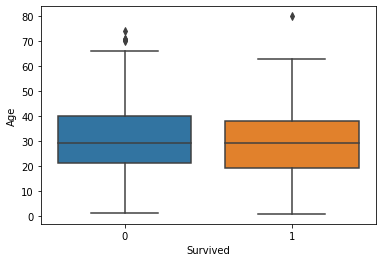

In [28]:
sns.boxplot(data=df_train, x='Survived', y='Age')

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

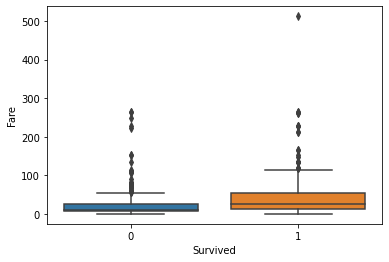

In [29]:
sns.boxplot(data=df_train, x='Survived', y='Fare')

<AxesSubplot:xlabel='Survived', ylabel='Parch'>

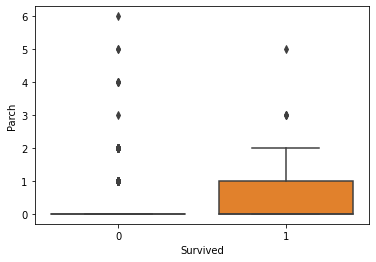

In [30]:
sns.boxplot(data=df_train, x='Survived', y='Parch')

### Model and predict

Create pipeline to preprocess data: impute values for the ones that have NaN and create dummies for categorical variables

1. Fill missing values for age and Embarked

In [31]:
# Nan values of Age will be replaced by the mean
# Nan values of Embarked will be replaced by the mode

imputer_mean = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer_mean = imputer_mean.fit(X_train[['Age']])
X_train['Age'] = imputer_mean.transform(X_train[['Age']])


imputer_mode = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer_mode = imputer_mode.fit(X_train[['Embarked']])
X_train['Embarked'] = imputer_mode.transform(X_train[['Embarked']])



In [32]:
print('Value imputed to age that have nan:',imputer_mean.statistics_)

Value imputed to age that have nan: [30.43917448]


In [33]:
print('Category imputed to embarked that have nan:',imputer_mode.statistics_)

Category imputed to embarked that have nan: ['S']


In [34]:
# Tranform the X_test with mean (of age) and mode (of embarked) from the train data

X_test['Age'] = imputer_mean.transform(X_test[['Age']])

X_test['Embarked'] = imputer_mode.transform(X_test[['Embarked']])

2. Encode categorical variables (Embarked and Sex)

In [35]:
X_train[['Sex','Embarked']]=X_train[['Sex','Embarked']].astype('category')
X_test[['Sex','Embarked']]=X_test[['Sex','Embarked']].astype('category')


X_train['Sex']=X_train['Sex'].cat.codes
X_train['Embarked']=X_train['Embarked'].cat.codes

X_test['Sex']=X_test['Sex'].cat.codes
X_test['Embarked']=X_test['Embarked'].cat.codes

#X_train = pd.get_dummies(X_train, prefix=['Sex', 'Embarked'])
#X_test = pd.get_dummies(X_test, prefix=['Sex', 'Embarked'])


### 1. Random forest with default hyperparameters

In [36]:
rfc = RandomForestClassifier(random_state=1107)

rfc.fit(X_train, y_train)

print(f'Accuracy in train dataset: {rfc.score(X_train, y_train)}')

print(f'Accuracy in test dataset: {rfc.score(X_test, y_test)}')

Accuracy in train dataset: 0.9880239520958084
Accuracy in test dataset: 0.8071748878923767


In [37]:
y_pred_rfc = rfc.predict(X_test)

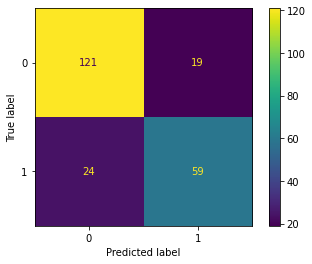

In [38]:
cm = confusion_matrix(y_test, y_pred_rfc, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=rfc.classes_)
disp.plot()

plt.show()

In [39]:
print(classification_report(y_test,y_pred_rfc))

# If i had predicted that all the passengers died, the accuracy would have been 0.63 (140/(140+83))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       140
           1       0.76      0.71      0.73        83

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223



### 2. Optimize model hyperparameters to select the better forest

2.1 Grid Search CV (tries with all the possible combinations)

In [40]:
param_grid = [{'max_depth': [8, 12, 16], 
         'min_samples_split': [12, 16, 20], 
         'criterion': ['gini', 'entropy']}]

print(param_grid)

[{'max_depth': [8, 12, 16], 'min_samples_split': [12, 16, 20], 'criterion': ['gini', 'entropy']}]


In [41]:
# GridSearchCV 

rfc2=RandomForestClassifier(random_state=1107)


grid =  GridSearchCV(estimator=rfc2, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.6s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.6s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=20; total time=   0.5s[CV] END ..criterion=gini, max_depth=8, min_samples_split=12; total time=   0.6s

[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=16; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=20; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=20; total time=   0.6s
[CV] END ..criterion=gini, max_depth=8, min_samples_split=20; total time=   0.5s
[CV] END ..criterion=gini, max_depth=8, min_samp

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1107),
             n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [8, 12, 16],
                          'min_samples_split': [12, 16, 20]}],
             verbose=2)

In [42]:
print('Best parameters:', grid.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 20}


In [43]:
print('Best model:', grid.best_estimator_) 

Best model: RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_split=20,
                       random_state=1107)


In [44]:
# Save best model
model_cv = grid.best_estimator_

In [45]:
# Accuracy in test data - option 1
y_pred_cv = model_cv.predict(X_test)

print('Accuracy of random forest selected by CV in test set (grid search):',np.mean(y_test==y_pred_cv))

Accuracy of random forest selected by CV in test set (grid search): 0.820627802690583


In [46]:
# Accuracy in test data - option 2 (more direct)

print('Accuracy of random forest selected by CV in test set (grid search):',grid.score(X_test, y_test))

Accuracy of random forest selected by CV in test set (grid search): 0.820627802690583


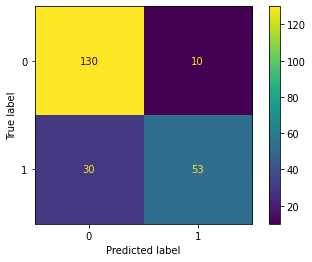

In [47]:
cm = confusion_matrix(y_test, y_pred_cv, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=grid.classes_)
disp.plot()

plt.show()

In [48]:
print(classification_report(y_test,y_pred_cv))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       140
           1       0.84      0.64      0.73        83

    accuracy                           0.82       223
   macro avg       0.83      0.78      0.80       223
weighted avg       0.82      0.82      0.81       223



Feature importance

In [49]:
importance = model_cv.feature_importances_
importance

array([0.12646553, 0.36289112, 0.17875048, 0.0515884 , 0.03810352,
       0.20594976, 0.03625119])

Feature: 0, Score: 0.12647
Feature: 1, Score: 0.36289
Feature: 2, Score: 0.17875
Feature: 3, Score: 0.05159
Feature: 4, Score: 0.03810
Feature: 5, Score: 0.20595
Feature: 6, Score: 0.03625


/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


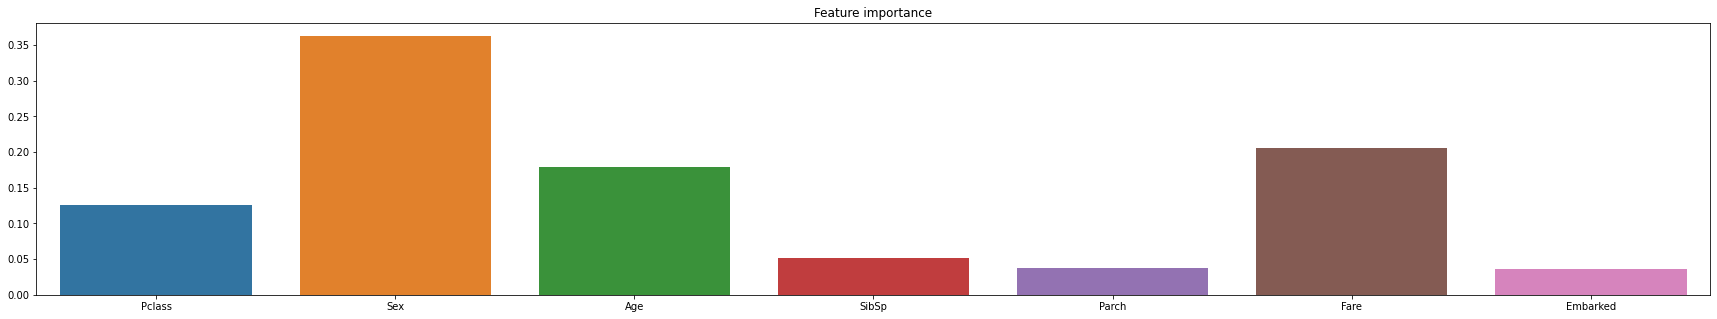

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [50]:
importance = model_cv.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# graficamos la importancia de las variables

plt.figure(figsize=(30,5))
columns = X.columns
sns.barplot(columns, importance)
plt.title('Feature importance')
plt.show()
columns

2.2 Randomized search CV

In this case, not all parameters values are tried out. This allows us to include more hyperparameters in the grid

In [51]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Criterio
criterion=['gini','entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
#'max_features': max_features, # Son muy pocas variables por lo cual no vale la pena aplicarlo
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap,
'criterion':criterion}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [52]:
rfc3=RandomForestClassifier(random_state=1107)

grid_random=RandomizedSearchCV(estimator=rfc3,n_iter=100,cv=5,random_state=1107,param_distributions=random_grid)
# n_iter: number of parameter settings that are sampled

In [53]:
grid_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1107),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1107)

In [54]:
print('Best parameters:', grid_random.best_params_) 

Best parameters: {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': True}


In [55]:
best_param = grid_random.best_params_
best_model = RandomForestClassifier(**best_param)
best_model

RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=1400)

In [56]:
print('Best model:', grid_random.best_estimator_) 

Best model: RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=1400,
                       random_state=1107)


In [57]:
# Save best model
model_cv_2 = grid_random.best_estimator_

In [58]:
# Accuracy in test data - option 1
y_pred_cv_2 = model_cv_2.predict(X_test)

print('Accuracy of random forest selected by CV in test set (random grid search):',np.mean(y_test==y_pred_cv_2))

Accuracy of random forest selected by CV in test set (random grid search): 0.8385650224215246


In [59]:
# Accuracy in test data - option 2

print('Accuracy of random forest selected by CV in test set (random grid search):',grid_random.score(X_test, y_test))

Accuracy of random forest selected by CV in test set (random grid search): 0.8385650224215246


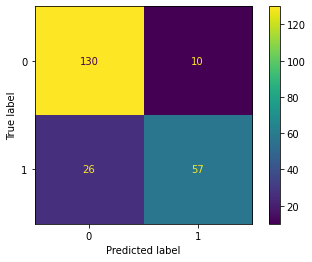

In [60]:
cm = confusion_matrix(y_test, y_pred_cv_2, labels=grid_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=grid_random.classes_)
disp.plot()

plt.show()

In [61]:
print(classification_report(y_test,y_pred_cv_2))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       140
           1       0.85      0.69      0.76        83

    accuracy                           0.84       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.84      0.84      0.83       223



Feature importance

Feature: 0, Score: 0.12381
Feature: 1, Score: 0.40103
Feature: 2, Score: 0.14712
Feature: 3, Score: 0.04866
Feature: 4, Score: 0.03502
Feature: 5, Score: 0.20627
Feature: 6, Score: 0.03809


/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


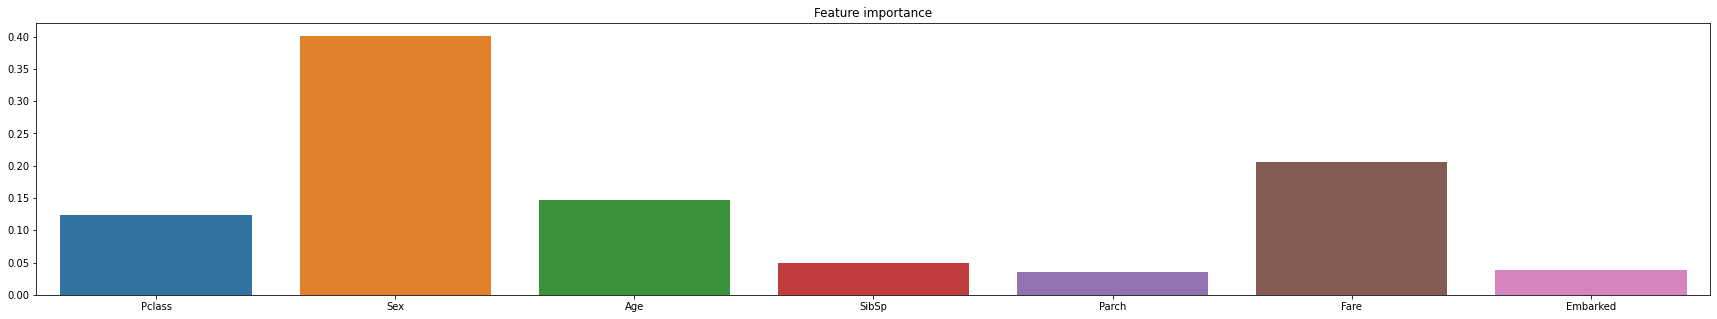

In [62]:
importance = model_cv_2.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# graficamos la importancia de las variables

plt.figure(figsize=(30,5))
columns = X_train.columns
sns.barplot(columns, importance)
plt.title('Feature importance')
plt.show()

- In both forests selected by cross-validation (one with grid search and the other one with random grid search) the most important features are: sex, age, fare and pclass
- The performance of the model in the test dataset did not improve sustantially between the random forest with hyperparameters chosen by grid search and the random forest with hyperparameters chosen by random grid search (and this one took more time because we included more hyperparameters in the search)

In [63]:
# Save best random forest model

filename = '../models/modelo_random_forest.sav'
pickle.dump(model_cv_2, open(filename, 'wb'))

### Boosting algorithms: XGBoost 

In [64]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [65]:
# Predictions
y_xgb_pred = xgb.predict(X_test)

In [66]:
print('Accuracy of xgboost in test set:',accuracy_score(y_test, y_xgb_pred))

Accuracy of xgboost in test set: 0.7802690582959642


- The accuracy of the xgboost with default hyperparameters is lower than the 3 random forests trained (two with tuned hyperparameters and one with default hyperparameters).

In [67]:
xgb_2 = XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid_xgb = RandomizedSearchCV(xgb_2,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=4,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'eta': [0.05, 0.1, 0.15, 0.2, 0.25,
                                                0.3],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='neg_log_loss')

In [68]:
xgb_2 = grid_xgb.best_estimator_

In [69]:
y_pred_xgb_2 = xgb_2.predict(X_test)

In [70]:
print('Accuracy of xgboost with hyperparameters selected by random grid search in test set:',accuracy_score(y_test, y_pred_xgb_2))

Accuracy of xgboost with hyperparameters selected by random grid search in test set: 0.8385650224215246


- The accuracy of the model xgboost with hyperparameters selected by random grid search is similar to the random forest with hyperparameters selected by grid search and is lower compared to the random forest with hyperparameters selected with random grid search (model_cv_2).